# APA Laboratori 6 - MLP and the RBF 

In [2]:
# Uncomment to upgrade packages
# !pip install pandas --upgrade 
# !pip install numpy --upgrade
# !pip install scipy --upgrade
# !pip install statsmodels --upgrade
# !pip install scikit-learn --upgrade
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def confusion(true, pred, classes):
    """
    Function for pretty printing confusion matrices
    """
    cm =pd.DataFrame(confusion_matrix(true, pred), index=classes,
                 columns=classes)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    return cm.style.highlight_max()


np.random.seed(4567)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Suppose we are interested in how variables, such as 

GRE (Graduate Record Exam scores)

GPA (Grade Point Average) and 

rank (prestige of the undergraduate institution)

affect admission into a graduate school.

 The target variable, admit/don't admit, is a binary variable, which we want to characterize
and, if possible, to predict (a model)

In [4]:
from pandas import read_csv

Admis = read_csv("Admissions.csv", delimiter=',')

 view the first few rows of the data

In [5]:
Admis.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


 We will treat all the variables gre and gpa as continuous. 

The variable rank takes on the values 1 through 4, so we can fairly treat it as numerical
(although, in rigour, it is ordinal)

In [6]:
Admis.describe()

N = Admis.shape[0]

,admit,gre,gpa,rank
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


 We first split the available data into learning and test sets, selecting randomly 2/3 and 1/3 of the data
 We do this for a honest estimation of prediction performance

In [7]:
from sklearn.model_selection import train_test_split

np.random.seed(63)
X_train, X_test, y_train, y_test = train_test_split(Admis.loc[:,'gre':], Admis.admit, test_size=0.33)

We start using logistic regression (a linear classifier)

In [8]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Binomial
from statsmodels.tools.tools import add_constant

model = GLM(y_train, add_constant(X_train), family=Binomial())
result = model.fit()
result.summary()
print('AIC=', result.aic)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  admit   No. Observations:                  268
Model:                            GLM   Df Residuals:                      264
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -151.65
Date:                Sun, 02 Sep 2018   Deviance:                       303.30
Time:                        04:07:31   Pearson chi2:                     265.
No. Iterations:                     4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3285      1.441     -2.309      0.021      -6.153      -0.503
gre            0.0025      0.001      1.842      0.066      -0.000       0.005
gpa            0.7622      0.420      1.815      0.069      -0.061       1.585
rank          -0.6534      0.157     -4.168      0.000      -0.961      -0.346
==============================================================================
"""

AIC= 311.29529549451223


As we can see `gre` has a very low weight, so we can test if eliminating that variable we can obtain an equivalent model

In [9]:
model = GLM(y_train, add_constant(X_train.loc[:,'gpa':]), family=Binomial())
result = model.fit()
result.summary()
print('AIC=', result.aic)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  admit   No. Observations:                  268
Model:                            GLM   Df Residuals:                      265
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -153.38
Date:                Sun, 02 Sep 2018   Deviance:                       306.75
Time:                        04:07:32   Pearson chi2:                     271.
No. Iterations:                     4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8166      1.400     -2.012      0.044      -5.560      -0.073
gpa            1.0625      0.389      2.735      0.006       0.301       1.824
rank          -0.6703      0.156     -4.308      0.000      -0.975      -0.365
==============================================================================
"""

AIC= 312.7544764268358


 The new model has one variable less and the error (residual deviance) is virtually the same (311.2 vs 312.7)

 Interpretation of the coefficients

In [10]:
result.params

const   -2.816583
gpa      1.062481
rank    -0.670304
dtype: float64

Calculation of apparent error in the training

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score

P=0.5

pred = result.predict(add_constant(X_train.loc[:,'gpa':]))
lab_tr = [1 if i>=P else 0 for i in pred]
confusion(y_train,lab_tr, ['noadmit','admit'])

(1-accuracy_score(y_train,lab_tr))*100

Predicted,noadmit,admit
Actual,,
noadmit,168,13
admit,60,27


27.23880597014925

 we get a learning error which is quite high (~27%)

 Estimation of prediction error using the test set

In [13]:
pred = result.predict(add_constant(X_test.loc[:,'gpa':]))
lab_tr = [1 if i>=P else 0 for i in pred]
confusion(y_test,lab_tr, ['noadmit','admit'])
(1-accuracy_score(y_test,lab_tr))*100

Predicted,noadmit,admit
Actual,,
noadmit,85,7
admit,33,7


30.303030303030297

 we get a prediction error of ~30%

 Now we switch to non-linear modelling with a MLP

In contrast to the nnet package from the R version, the MLP implementation from scikit learn is fully capable and has more features but we will restrict the model to only one hidden later

The basic parameters are 'hidden_layer_sizes' and 'alpha' (the regularization constant, lambda)

It buils a MLP with one output neuron (just two classes), with the logistic function
and uses the cross-entropy as error function

 Let's start by standardizing of inputs, this is important to avoid network 'stagnation' (premature convergence)

In [14]:
from sklearn.preprocessing import StandardScaler

Admis.loc[:,'gre':] = StandardScaler().fit_transform(Admis.loc[:,'gre':])
Admis.head()
X_train, X_test, y_train, y_test = train_test_split(Admis.loc[:,'gre':], Admis.admit, test_size=0.33)

,admit,gre,gpa,rank
0,0,-1.800263,0.579072,0.545968
1,1,0.626668,0.736929,0.545968
2,1,1.840134,1.605143,-1.574296
3,1,0.453316,-0.525927,1.606100
4,0,-0.586797,-1.209974,1.606100


To illustrate the first results, we just fit a MLP with 2 hidden neurons

In [15]:
from sklearn.neural_network import MLPClassifier

model_nnet = MLPClassifier(hidden_layer_sizes=[2],alpha=0,activation='logistic',max_iter=200,solver='lbfgs')
model_nnet.fit(X_train,y_train);


 This is the final value of the error function (also known as fitting criterion)

In [16]:
model_nnet.loss_

0.5616482696812253

 Now look at the weights

In [17]:
model_nnet.coefs_
model_nnet.intercepts_

[array([[-3.69158005e-04,  2.44099747e+02],
        [ 5.52082974e-04,  6.54458943e+02],
        [ 1.00624829e-02,  3.38028739e+02]]), array([[-250.87036692],
        [   1.87276524]])]

[array([1.70581207e-01, 5.83679120e+02]), array([133.75286088])]

It is a bit clearer if we draw the network

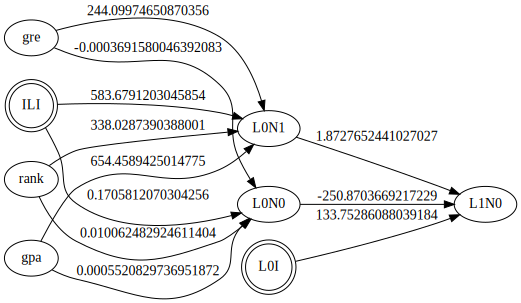

In [18]:
from graphviz import Digraph
def graphMLP(vars,layers,intercepts):
    f = Digraph('')
    f.attr(rankdir='LR')
    for i,l in enumerate(layers):
        if i==0:
            for j in range(l.shape[1]):
                for k, v in enumerate(vars):
                    f.edge(v, 'L%dN%d'%(i,j), label=str(l[k,j]))
            f.node('ILI', shape='doublecircle')                    
            for k in range(intercepts[i].shape[0]): 
                f.edge('ILI', 'L%dN%d'%(i,k), label=str(intercepts[i][k]))
        else:
            for j in range(l.shape[1]):
                for k in range(layers[i-1].shape[1]):
                    f.edge('L%dN%d'%(i-1,k), 'L%dN%d'%(i,j), label=str(l[k,j]))
            f.node('L%dI'%(i-1), shape='doublecircle')                  
            for k in range(intercepts[i].shape[0]):
                f.edge('L%dI'%(i-1), 'L%dN%d'%(i,k), label=str(intercepts[i][k]))    
                
    return f

graphMLP(Admis.columns[1:], model_nnet.coefs_, model_nnet.intercepts_)

 i1,i2,i3 are the 3 inputs, h1, h2 are the two hidden neurons, b is the bias (offset)

 As you can see, some weights are large (two orders of magnitude larger then others)
This is no good, since it makes the model unstable (i.e., small changes in some inputs may
 entail significant changes in the network, because of the large weights)

 One way to avoid this is by regularizing the learning process:

In [19]:
model_nnet = MLPClassifier(hidden_layer_sizes=[2],alpha=0.01,activation='logistic',max_iter=200,solver='lbfgs')

model_nnet.fit(X_train,y_train);

 notice the big difference

In [20]:
model_nnet.coefs_
model_nnet.intercepts_

[array([[-0.09763063,  5.25803333],
        [-0.04545448, 11.37823487],
        [ 1.43319628,  5.1025007 ]]), array([[-2.08999528],
        [ 1.67653814]])]

[array([-0.04645992, 10.29491737]), array([-1.16194655])]

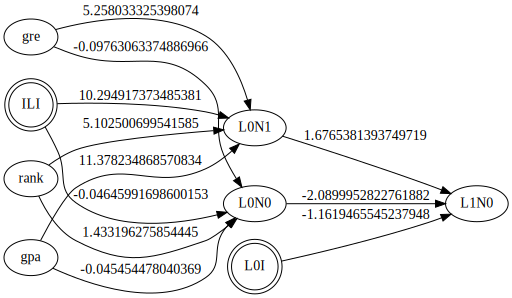

In [21]:
graphMLP(Admis.columns[1:], model_nnet.coefs_, model_nnet.intercepts_)

Now let's compute the training error

In [22]:
pred = model_nnet.predict(X_train)
(1-accuracy_score(y_train,pred))*100

30.22388059701493

 And the corresponding test error

In [23]:
pred = model_nnet.predict(X_test)
(1-accuracy_score(y_test,pred))*100

24.242424242424242

 We get 24.24%, so it seems that the MLP helps a little bit; however, we need to work harder

 We are going to do the modelling in a principled way now. Using 10x10 CV to select the best
 combination of 'size' and 'decay'

 Just by curiosity, let me show you that we can fit any dataset (in the sense of reducing the training error):

In [24]:
model_nnet = MLPClassifier(hidden_layer_sizes=[30],alpha=0,activation='logistic',max_iter=500,solver='lbfgs')
model_nnet.fit(X_train,y_train);


In [25]:
pred = model_nnet.predict(X_train)

confusion(y_train,pred, ['noadmit','admit'])
(1-accuracy_score(y_train,pred))*100

Predicted,noadmit,admit
Actual,,
noadmit,180,3
admit,3,82


2.238805970149249

And the corresponding test error

In [26]:
pred = model_nnet.predict(X_test)
confusion(y_test,pred, ['noadmit','admit'])
(1-accuracy_score(y_test,pred))*100

Predicted,noadmit,admit
Actual,,
noadmit,66,24
admit,29,13


40.15151515151515

that's it: we got a training error around 2%, but it is 
illusory ... the test error is larger than before (around 40%); 
 The relevant comparison is between 2% and 40%, this large gap is an indication of overfitting



Scikit learn has specific functions for parameter search so we can tune the parameters of a model.

 We are going to use a grid search that will use a cross validation strategy to evaluate the results for each combination of parameters. At the end the best model will be returned

 In order to find the best network architecture, we are going to explore two methods:

1. Explore different numbers of hidden units in one hidden layer, with no regularization
2. Fix a large number of hidden units in one hidden layer, and explore different regularization values (recommended)

doing both (explore different numbers of hidden units AND regularization values) is usually a waste of computing 
resources (but notice that it would admit it)

Let's start with 1.

set desired sizes

In [27]:
sizes = [2*i for i in range(1,11)]
sizes

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

In [28]:
from sklearn.model_selection import GridSearchCV

model_nnet = MLPClassifier(alpha=0,activation='logistic',max_iter=500,solver='lbfgs')
trc = GridSearchCV(estimator=model_nnet, param_grid ={'hidden_layer_sizes':sizes},cv=10,return_train_score=True)
model_10CV = trc.fit(X_train,y_train)
model_10CV.best_score_


0.667910447761194

In [32]:
pd.DataFrame(model_10CV.cv_results_).loc[:,['param_hidden_layer_sizes','mean_test_score', 'std_test_score','rank_test_score' ]].style.highlight_max(subset=['mean_test_score'])

,param_hidden_layer_sizes,mean_test_score,std_test_score,rank_test_score
0,2,0.656716,0.0485689,2
1,4,0.623134,0.0809708,5
2,6,0.626866,0.0666534,4
3,8,0.66791,0.0568779,1
4,10,0.619403,0.0546631,7
5,12,0.630597,0.113339,3
6,14,0.585821,0.0803639,9
7,16,0.55597,0.108956,10
8,18,0.623134,0.0783204,5
9,20,0.593284,0.075385,8


and the best model found

In [33]:
model_10CV.best_params_

{'hidden_layer_sizes': 8}

 The results are quite disappointing ...

 Now method 2.

In [34]:
decays = [10**i for i in np.arange(-3,0,0.1)]
decays

[0.001,
 0.0012589254117941675,
 0.001584893192461114,
 0.0019952623149688807,
 0.002511886431509582,
 0.0031622776601683824,
 0.003981071705534978,
 0.00501187233627273,
 0.006309573444801942,
 0.00794328234724283,
 0.010000000000000021,
 0.012589254117941701,
 0.015848931924611172,
 0.01995262314968885,
 0.025118864315095874,
 0.03162277660168389,
 0.03981071705534985,
 0.0501187233627274,
 0.06309573444801955,
 0.07943282347242846,
 0.10000000000000041,
 0.12589254117941726,
 0.15848931924611206,
 0.1995262314968889,
 0.25118864315095923,
 0.31622776601683955,
 0.39810717055349937,
 0.501187233627275,
 0.6309573444801969,
 0.7943282347242863]

 WARNING: this takes a few minutes

In [35]:
model_nnet = MLPClassifier(alpha=0,activation='logistic',hidden_layer_sizes=20,max_iter=500,solver='lbfgs')
trc = GridSearchCV(estimator=model_nnet, param_grid ={'alpha':decays},cv=10,return_train_score=True)
model_10CV = trc.fit(X_train,y_train)
model_10CV.best_score_


0.6828358208955224

In [37]:
pd.DataFrame(model_10CV.cv_results_).loc[:,['param_alpha','mean_test_score', 'std_test_score','rank_test_score' ]].style.highlight_max(subset=['mean_test_score'])

,param_alpha,mean_test_score,std_test_score,rank_test_score
0,0.001,0.589552,0.0938038,21
1,0.00125893,0.634328,0.0363673,12
2,0.00158489,0.585821,0.0619938,22
3,0.00199526,0.574627,0.102873,27
4,0.00251189,0.559701,0.0954089,30
5,0.00316228,0.600746,0.0873144,20
6,0.00398107,0.58209,0.105672,24
7,0.00501187,0.604478,0.063994,17
8,0.00630957,0.578358,0.0894927,25
9,0.00794328,0.578358,0.0815832,25


In [38]:
model_10CV.best_params_

{'alpha': 0.31622776601683955}

 The results are a bit better; we should choose the model with the lowest 10x10CV error overall,
 in this case it corresponds to 20 hidden neurons, with a decay of 0.3162278

 So what remains is to predict the test set with our final model

In [39]:
pred = model_10CV.predict(X_test)

(1-accuracy_score(y_test,pred))*100

31.818181818181824

 We get ~32% after all this work; it seems that the information in this dataset is not enough
 to accurately predict admittance. Note that ...

 ... upon looking at the confusion matrix for the predictions ...

In [40]:
confusion(y_test,pred, ['noadmit','admit'])

Predicted,noadmit,admit
Actual,,
noadmit,84,6
admit,36,6


 it clearly suggests that quite a lot of people is getting accepted when they should not, given their gre, gpa and rank
 It is very likely that other (subjective?) factors are being taken into account, that are not in the dataset

***

## Multilayer Perceptron Example 2: circular artificial 2D data

<IPython.core.display.Javascript object>


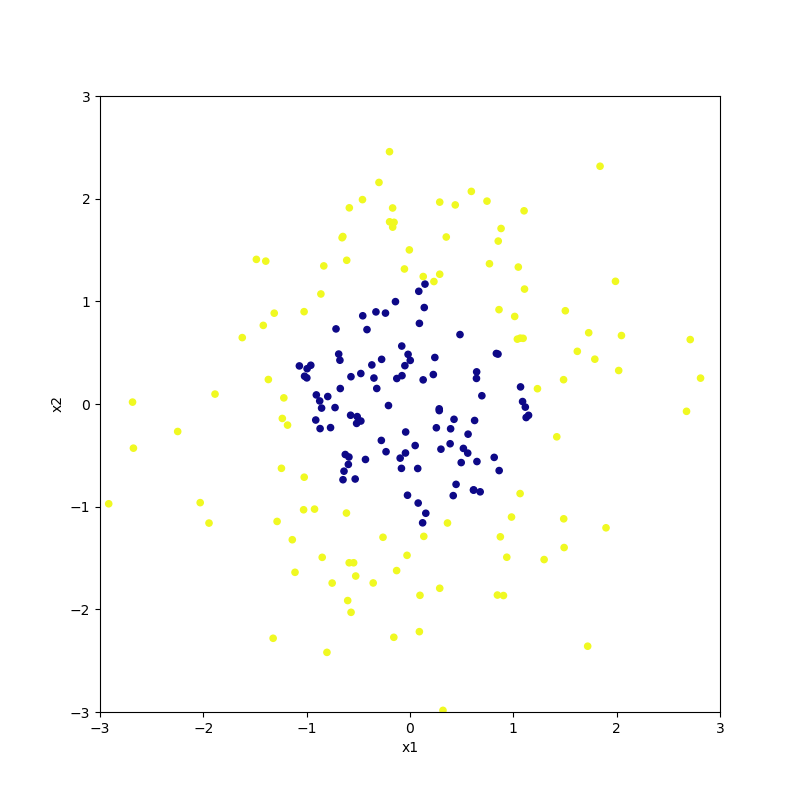

In [41]:
from numpy.random import normal

np.random.seed(3)
p = 2
N = 200

x = normal(size=N*p).reshape(-1,2)
y = (x[:,0]**2+x[:,1]**2 > 1.4).astype('int')

mydata = pd.DataFrame({'x1':x[:,0],'x2':x[:,1],'y':y})
mydata

mydata.plot.scatter(x='x1',y='x2',c='y', colormap='plasma',figsize=(8,8),colorbar=False,xlim=[-3,3],ylim=[-3,3]);

 Let's use one hidden layer, 3 hidden units, no regularization and the error function "cross-entropy"
 In this case it is not necessary to standardize because they variables already are
 (they have been generated from a distribution with mean 0 and standard deviation 1).

In [42]:
np.random.seed(30)
nn1= MLPClassifier(alpha=0,activation='logistic',hidden_layer_sizes=3,max_iter=2000,solver='lbfgs')
nn1.fit(mydata.loc[:,'x1':'x2'],mydata.y);
mydata['yhat']=nn1.predict(mydata.loc[:,'x1':'x2']);



<IPython.core.display.Javascript object>


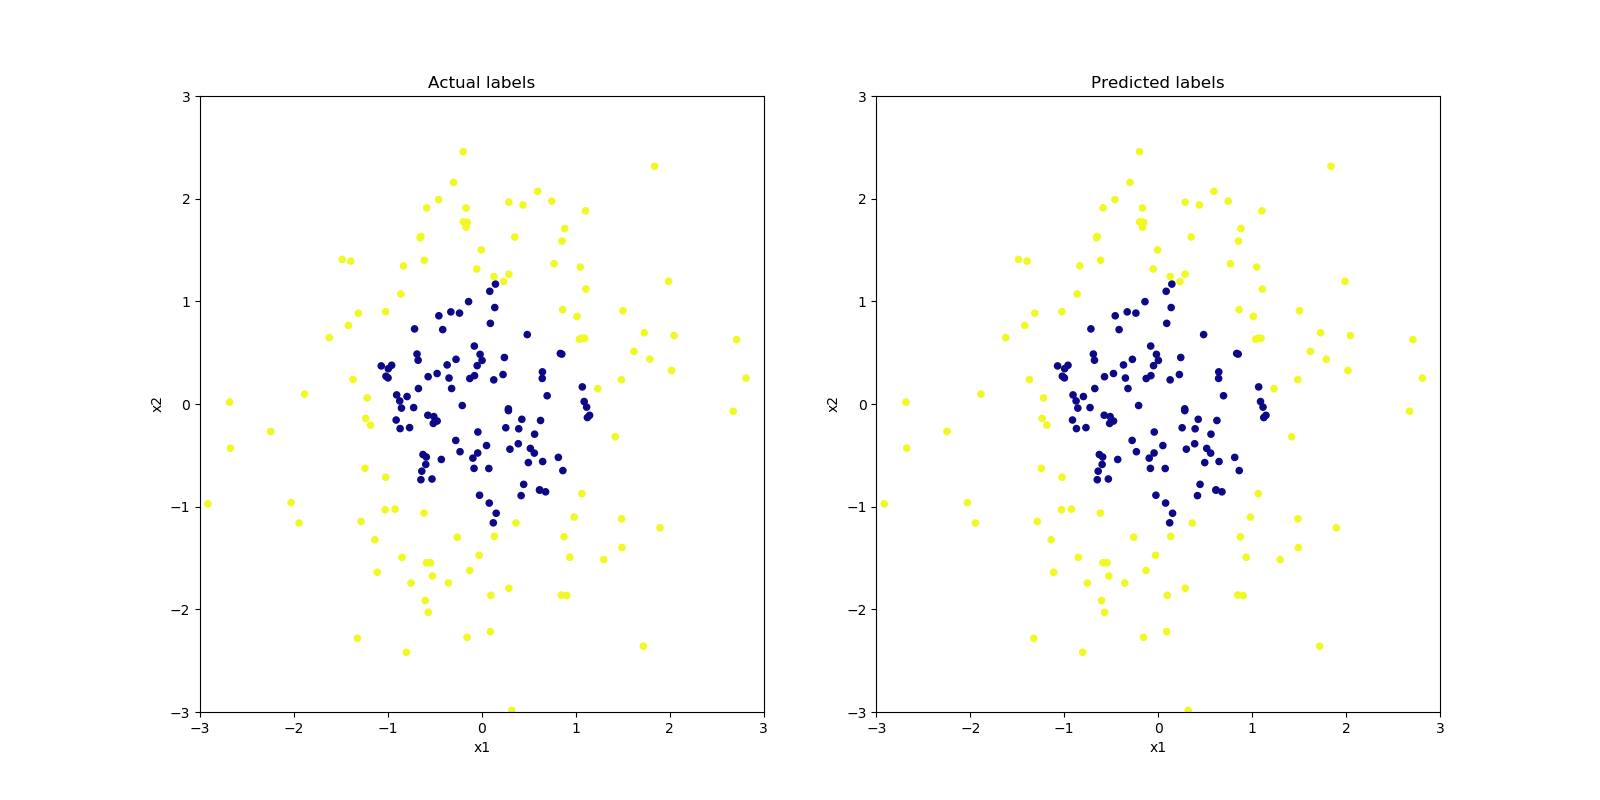

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
mydata.plot.scatter(x='x1',y='x2',c='y', colormap='plasma',colorbar=False,xlim=[-3,3],ylim=[-3,3],ax=ax1,title='Actual labels')
mydata.plot.scatter(x='x1',y='x2',c='yhat', colormap='plasma',colorbar=False,xlim=[-3,3],ylim=[-3,3],ax=ax2,title='Predicted labels');

In [44]:
confusion(mydata.y,mydata.yhat,[0,1])


Predicted,0,1
Actual,,
0,96,0
1,0,104


Excellent, indeed

 Let's execute it again, this time wth a different random seed

<IPython.core.display.Javascript object>


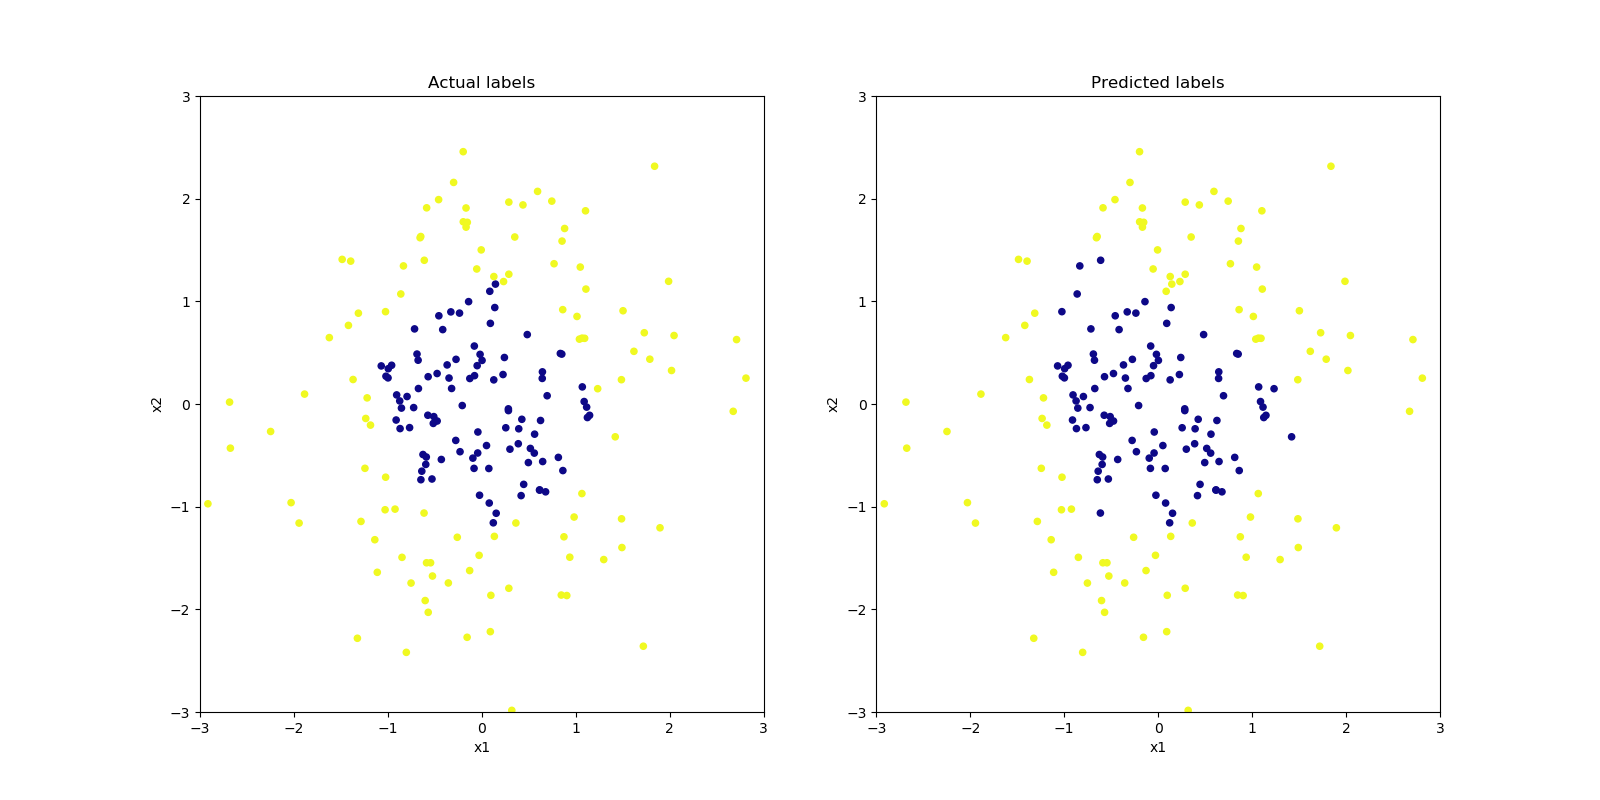

In [45]:
np.random.seed(3)
nn1= MLPClassifier(alpha=0,activation='logistic',hidden_layer_sizes=3,max_iter=2000,solver='lbfgs')
nn1.fit(mydata.loc[:,'x1':'x2'],mydata.y);
mydata['yhat']=nn1.predict(mydata.loc[:,'x1':'x2']);
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
mydata.plot.scatter(x='x1',y='x2',c='y', colormap='plasma',colorbar=False,xlim=[-3,3],ylim=[-3,3],ax=ax1,title='Actual labels')
mydata.plot.scatter(x='x1',y='x2',c='yhat', colormap='plasma',colorbar=False,xlim=[-3,3],ylim=[-3,3],ax=ax2,title='Predicted labels');

In [46]:
confusion(mydata.y,mydata.yhat, [0,1])

Predicted,0,1
Actual,,
0,94,2
1,7,97


 we see that the optimizer does not always find a good solution, even with the right number of neurons

 How many hidden units do we need?

<IPython.core.display.Javascript object>


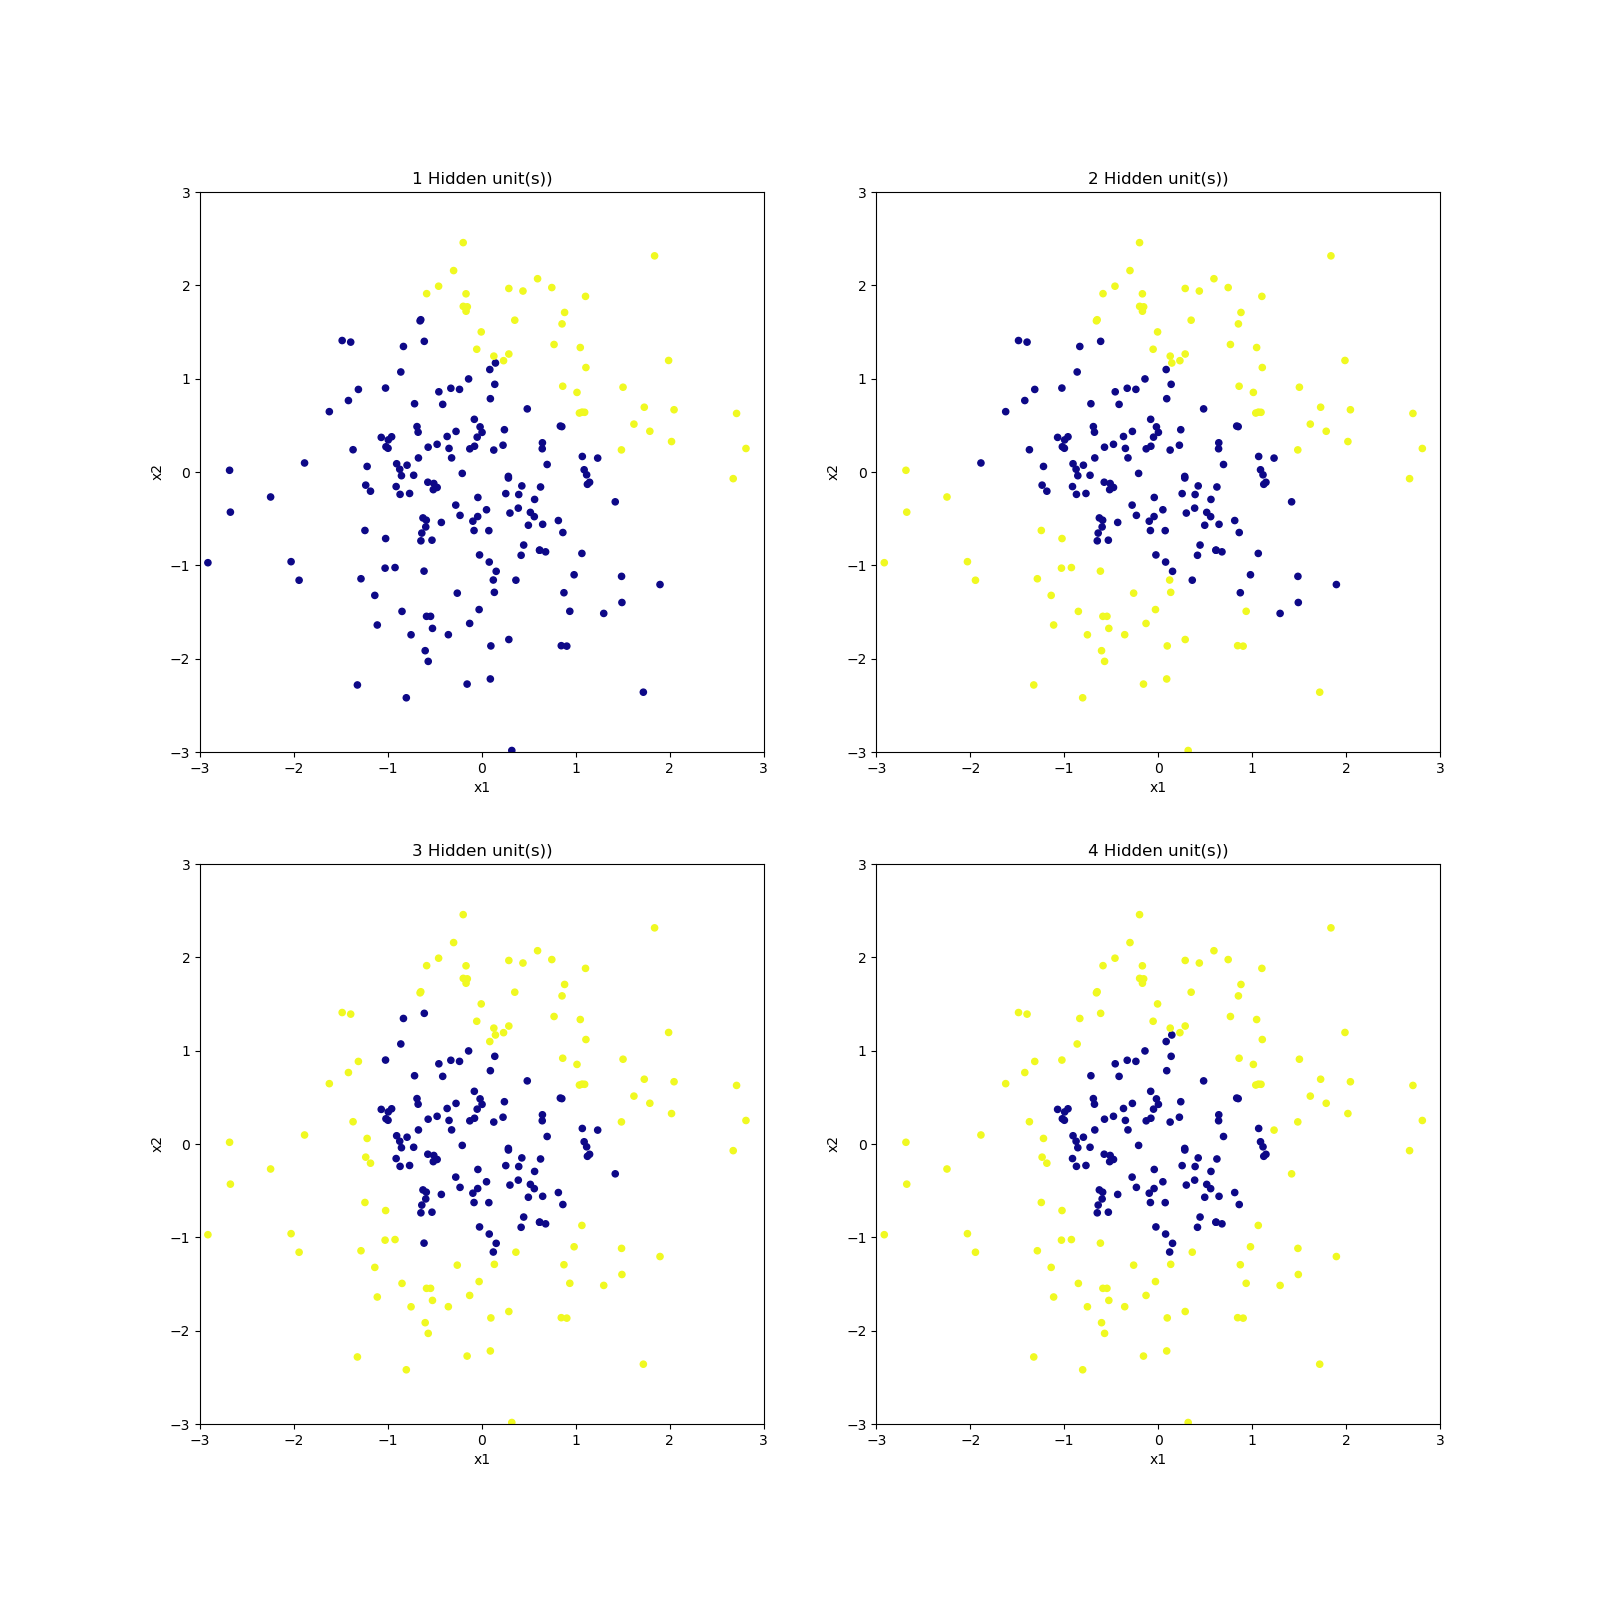

In [47]:
fig, ax = plt.subplots(2,2,figsize=(16,16))
for i,a in zip(range(1,5),ax.ravel()):
    np.random.seed(3)
    nn1= MLPClassifier(alpha=0,activation='logistic',hidden_layer_sizes=i,max_iter=2000,solver='lbfgs')
    nn1.fit(mydata.loc[:,'x1':'x2'],mydata.y);
    mydata['yhat']=nn1.predict(mydata.loc[:,'x1':'x2']);
    mydata.plot.scatter(x='x1',y='x2',c='yhat', colormap='plasma',colorbar=False,xlim=[-3,3],ylim=[-3,3],ax=a,title='%d Hidden unit(s))'%i)
0;

 Let's find out which function has been learned exactly, with 3 units

In [48]:
np.random.seed(3)
nn1= MLPClassifier(alpha=0.01,activation='logistic',hidden_layer_sizes=3,max_iter=3000,solver='lbfgs')
nn1.fit(mydata.loc[:,'x1':'x2'],mydata.y);

In [49]:
x1grid = np.linspace(-3.0, 3.0, 200)
x2grid = np.linspace(-3.0, 3.0, 200)
X,Y = np.meshgrid(x1grid, x2grid)
Ones = np.ones((200,200))

In [50]:
v1 = (X*nn1.coefs_[0][0,0] + Y * nn1.coefs_[0][1,0] + Ones * nn1.intercepts_[0][0])
v2 = (X*nn1.coefs_[0][0,1] + Y * nn1.coefs_[0][1,1] + Ones * nn1.intercepts_[0][1])
v3 = (X*nn1.coefs_[0][0,2] + Y * nn1.coefs_[0][1,2] + Ones * nn1.intercepts_[0][2])

<IPython.core.display.Javascript object>


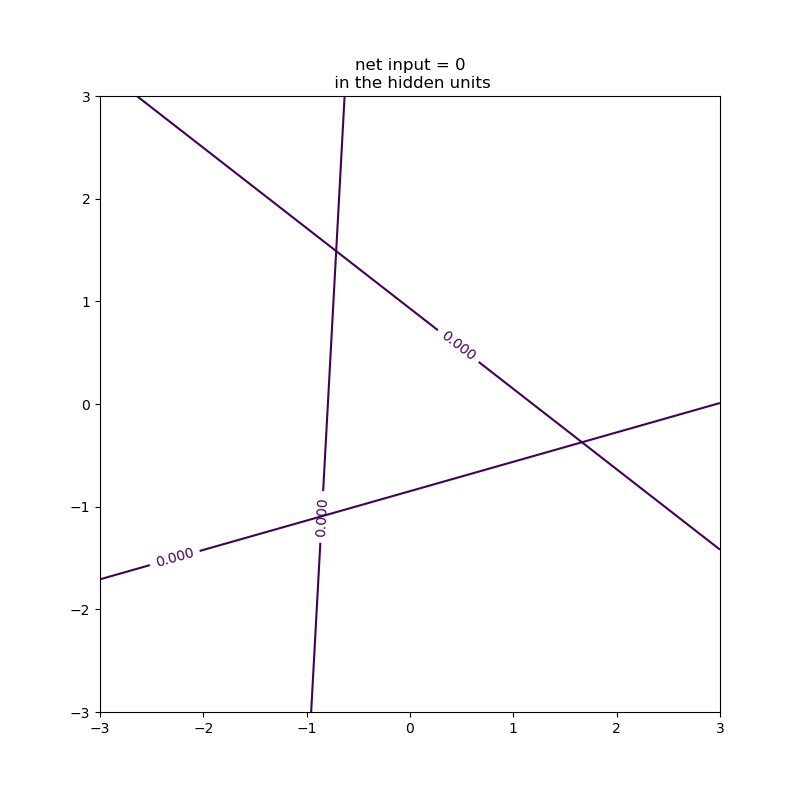

In [51]:
fig, ax = plt.subplots(figsize=(8,8))
CS = ax.contour(X, Y, v1,levels=0)
plt.clabel(CS, inline=1, fontsize=10)
CS = ax.contour(X, Y, v2,levels=0)
plt.clabel(CS, inline=1, fontsize=10)
CS = ax.contour(X, Y, v3,levels=0)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('net input = 0\n in the hidden units');

 this is the logistic function, used by nnet() for the hidden neurons, and 
 for the output neurons in two-class classification problems

<IPython.core.display.Javascript object>


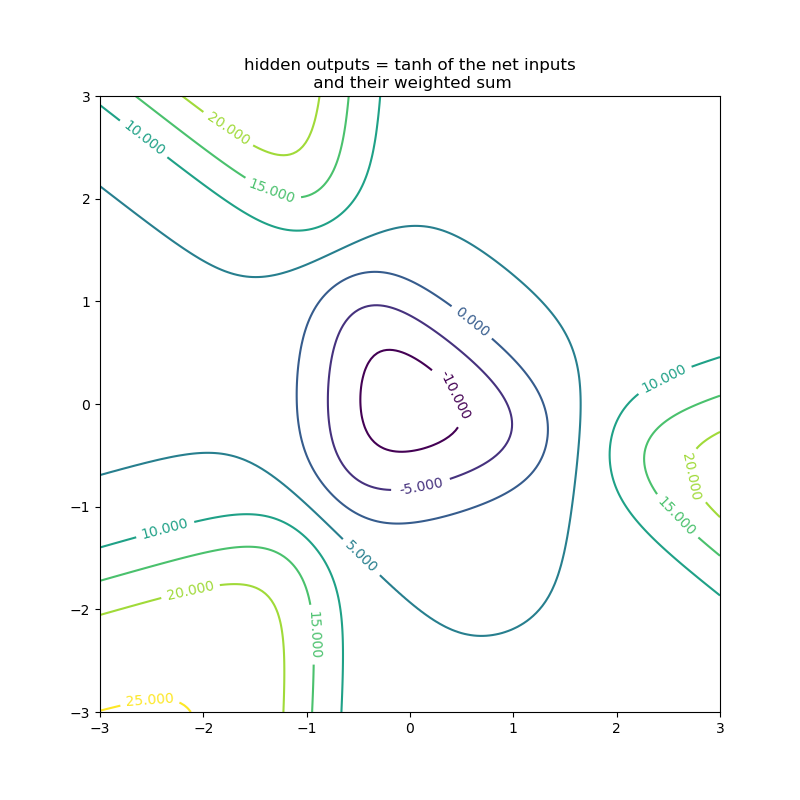

In [52]:
#def logistic(x): return 1/(1+np.exp(-x))
from scipy.special import expit as logistic


z = nn1.intercepts_[1][0] + nn1.coefs_[1][0] * logistic(v1) + nn1.coefs_[1][1] * logistic(v2) + nn1.coefs_[1][2] * logistic(v3) 
fig, ax = plt.subplots(figsize=(8,8))

CS = ax.contour(X, Y, z)
plt.clabel(CS, fontsize=10)
plt.title('hidden outputs = tanh of the net inputs\n and their weighted sum');

<IPython.core.display.Javascript object>


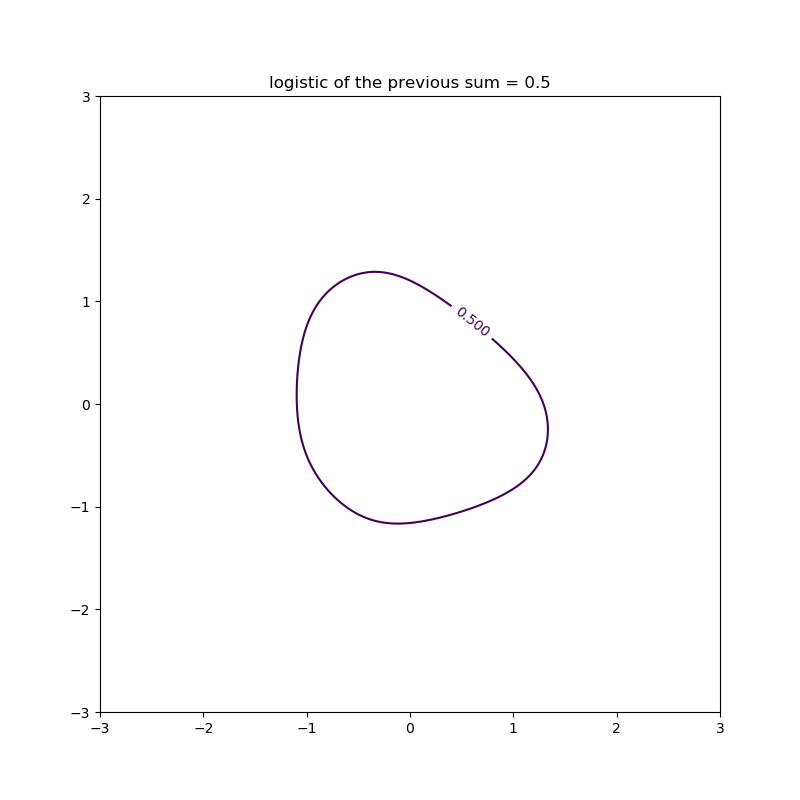

In [53]:
fig, ax = plt.subplots(figsize=(8,8))
CS = ax.contour(X, Y, logistic(z),levels=0.5)
plt.clabel(CS, fontsize=10)
plt.title('logistic of the previous sum = 0.5');

<IPython.core.display.Javascript object>


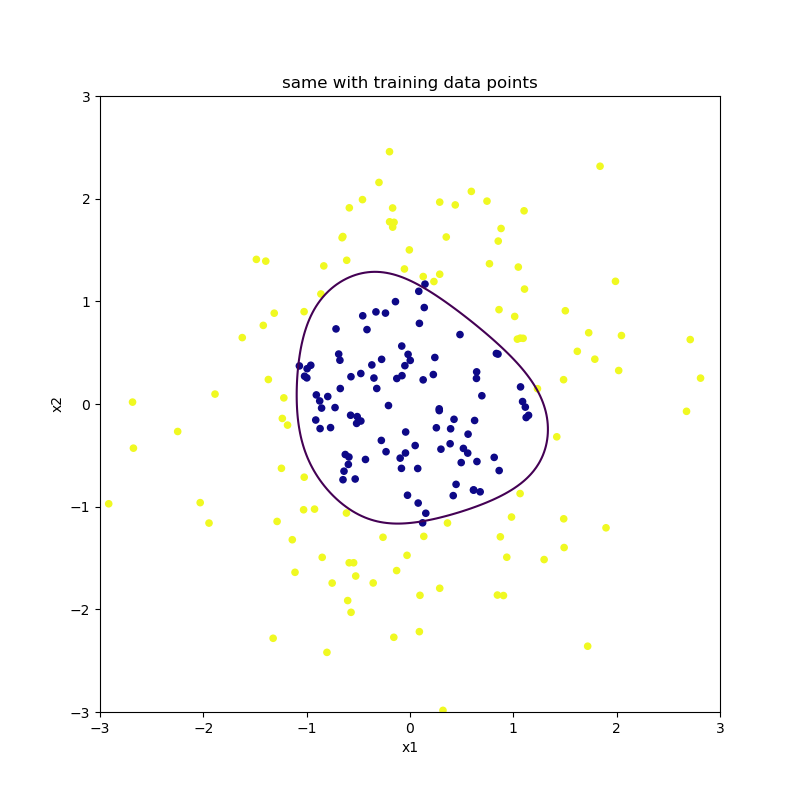

In [54]:
ax =mydata.plot.scatter(x='x1',y='x2',c='y', colormap='plasma',figsize=(8,8),colorbar=False,xlim=[-3,3],ylim=[-3,3],title='same with training data points')
CS = ax.contour(X, Y, logistic(z),levels=0.5)

 If you prefer a more visual demo of how ANN work, you can play with the Google's tensorflow playground http://playground.tensorflow.org

***

## Radial Basis Function Network Example: regression of a 1D function

 We are going to do all the computations "by hand"

Let us depart from the following function in the (a,b) interval

In [55]:
def myf(x): return (1 + x - 2*x**2) * np.exp(-x**2)

We are going to model this function in the interval (-5,5)

In [56]:
from numpy.random import uniform
np.random.seed(3)

N = 200
a=-5
b=5

def myf_data(N,a,b):
    x = uniform(a,b,N)
    return pd.DataFrame({'x':x, 't': myf(x) + normal(scale=0.2,size=N)})
d = myf_data(N,a,b)

d.describe()

,x,t
count,200.000000,200.000000
mean,-0.020155,0.031026
std,2.837250,0.406581
min,-4.760181,-1.023215
25%,-2.448918,-0.206763
50%,-0.169587,-0.014613
75%,2.280411,0.188214
max,4.779524,1.283748


The black points are the data, the blue line is the true underlying function

<IPython.core.display.Javascript object>


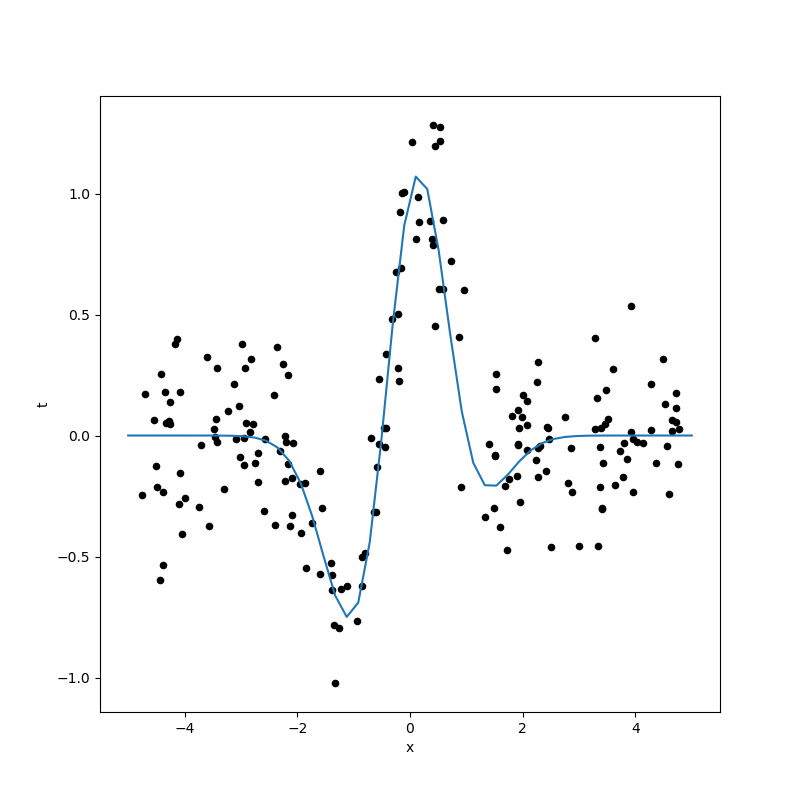

In [57]:
ax = d.plot.scatter(x='x',y='t',figsize=(8,8),c='black');
ax.plot(np.linspace(-5,5), myf(np.linspace(-5,5)));

 Create a large test data too for future use; notice that the generation mechanism is the same

In [58]:
N_test=2000
d_test = myf_data(N_test,a,b)


Function to compute a PHI (N x M) design matrix, without the Phi_0(x) = 1 column;
 m.i, h.i are the centers and variances (sigmas) of the neurons, respectively

In [59]:
def PHI(x,m_i,h_i):
  N = x.shape[0]
  M = m_i.shape[0]
  phis = np.zeros((M,N))
  for i in range(M):
    phis[i:] = np.exp(-(x - m_i[i])**2/(2*h_i[i]))
  return phis.T


 We find the centers and variances for each neuron using k-means; since this clustering algorithm is non-deterministic (because the initial centers are random), we do it 'NumKmeans' times

In [60]:
NumKmeans = 10

We set a rather large number of hidden units (= basis functions) M as a function of data size (the sqrt is just a heuristic!) because we are going to try different regularizers

In [61]:
M = int(np.floor(np.sqrt(N)))


In [62]:
from sklearn.cluster import KMeans

m = []
h = []
data_Kmeans=np.array(d.x).reshape(-1, 1)

for j in range(1,NumKmeans+1):
    # Find the centers m.i with k-means
    km = KMeans(n_clusters=M)
    km.fit(data_Kmeans)
    m.append(km.cluster_centers_[:,0])

    # Obtain the variances h_i as a function of the m_i
    th = np.zeros(M)
    for i in range(M):
        nind = data_Kmeans[km.labels_==i].shape[0]
        th[i] = np.sum(np.abs(data_Kmeans[km.labels_==i]-m[j-1][i]))/nind
        if th[i]==0:
            th[i]=1
    h.append(th)
0;

 Now for each k-means we get the hidden-to-output weights by solving a regularized
 least-squares problem (standard ridge regression), very much as we did in previous labs

The difference is that now we perform ridge regression on the PHI matrix (that is, on the new regressors given by the hidden neurons), not on the original inputs ...

 ... and find the best lambda with using GCV across all choices of basis functions (the NumKmeans clusterings)

In [63]:
from sklearn.linear_model import RidgeCV, Ridge

lambdes = 10**np.arange(-3,1.5,0.1)

errors = []
bestLambdes = []

for num in range(1,NumKmeans+1):
    m_i = m[num-1]
    h_i = h[num-1]
    myPHI = PHI(d.x,m_i,h_i)
    ridgecv = RidgeCV(alphas=lambdes,normalize=True)
    ridgecv.fit(myPHI,d.t)
    ridge=Ridge(alpha=ridgecv.alpha_,normalize=True).fit(myPHI,d.t)
    errors.append(ridge.score(myPHI,d.t))
    bestLambdes.append(ridgecv.alpha_)
                                                          
0;

 Now we obtain the best model among the tested ones

In [64]:
bestIndex = np.argmin(errors)
bestLambda =bestLambdes[bestIndex]
m_i = m[bestIndex]
h_i = h[bestIndex]

 we see that this problem needs a lot of regularization! This makes sense if you take a look at how the data is generated (the previous plot): the noise level is very high relative to the signal

 We also see that the best lambda fluctuates (since the data changes  due to the clustering, but the order of magnitude is quite stable

In [65]:
bestLambdes

[0.0031622776601683824,
 0.00794328234724283,
 0.01995262314968885,
 0.01995262314968885,
 0.015848931924611172,
 0.01995262314968885,
 0.00501187233627273,
 0.01995262314968885,
 0.00794328234724283,
 0.01995262314968885]

 We now create the final model:

In [66]:
myRBF=Ridge(alpha=bestLambda,normalize=True).fit(PHI (d.x,m_i,h_i),d.t)

these are the final hidden-to-output weights: note how small they are (here is where we regularize)

In [67]:
weights = np.hstack((np.array(myRBF.intercept_), myRBF.coef_))
pd.DataFrame(weights, index=['w_%d'%i for i in range(weights.shape[0])])

,0
w_0,-0.113106
w_1,0.199956
w_2,0.131246
w_3,0.101632
w_4,-0.375632
w_5,0.062464
w_6,0.880165
w_7,0.074199
w_8,0.136244
w_9,0.768077


 It remains to calculate the prediction on the test data

In [68]:
test_PHI = np.hstack((np.ones(N_test).reshape(-1,1),PHI(d_test.x,m_i,h_i)))
y = test_PHI @ weights


 And now the normalized error of this prediction

In [69]:
errorsTest = np.sqrt(np.sum((d_test.t - y)**2)/((N_test-1)*np.var(d_test.t)))
errorsTest

0.5234342003825634

Much better if we plot everything

 Test data in black,  Red data are the predictions  and the blue line is the underlying function

<IPython.core.display.Javascript object>


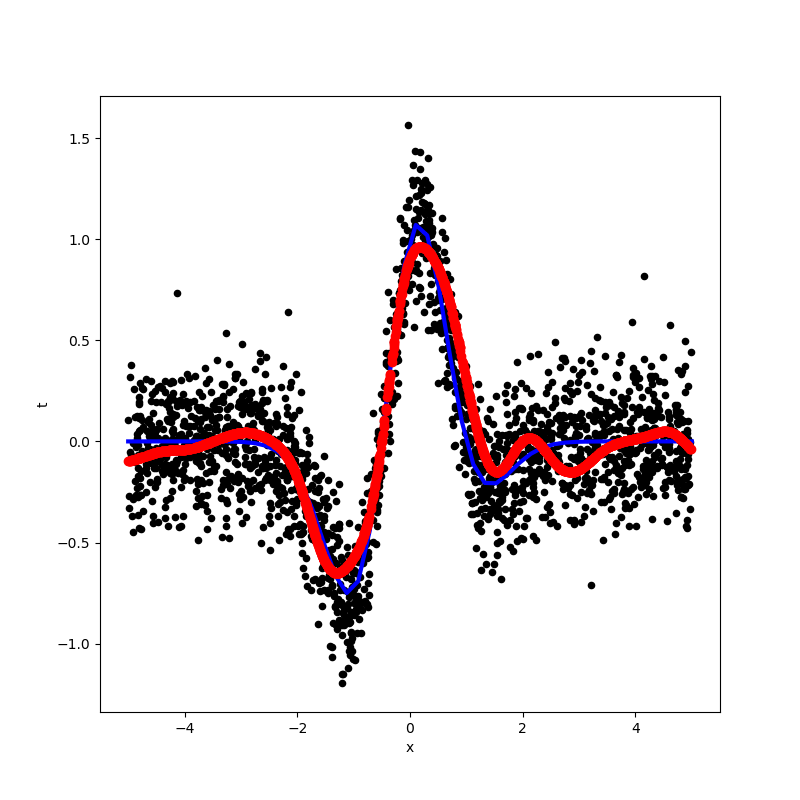

In [70]:
ax = d_test.plot.scatter(x='x',y='t',figsize=(8,8),c='black');
ax.plot(np.linspace(-5,5), myf(np.linspace(-5,5)),'b-',linewidth=3);

ax.plot(d_test.x,y,'ro');

Currently we are in the era of neural networks applications and there are very good neural network libraries for python (and other languages) like Tensorflow/Keras (from Google), pytorch (from Facebook) or MxNet (from Amazon) amnong others.

They are more complex but are prepared for large quantities of data using GPU training and are used for many applications in artificial intelligence like computer vision and natural language understanding